In [1]:
import pandas as pd
import numpy as np


In [2]:
raw_df = pd.read_csv("2018.csv", low_memory=False)
raw_df = raw_df.sample(frac=1).reset_index(drop=True)

print(raw_df.shape)

(7213446, 28)


In [3]:
valid_y = raw_df.TAXI_IN.notnull()
df = raw_df[valid_y]
print(df.shape)
# subsample
#df = df[0:100000]

(7094200, 28)


In [4]:
tab_info = pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info = tab_info.append(pd.DataFrame(df.count()).T.rename(index={0:'number of valid values'}))
tab_info = tab_info.append(pd.DataFrame(df.nunique()).T.rename(index={0:'number of unique values'}))
tab_info

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
column type,object,object,int64,object,object,int64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,0,0,4737,0,0,...,7,15196,15196,0,5741490,5741490,5741490,5741490,5741490,7094200
number of valid values,7094200,7094200,7094200,7094200,7094200,7094200,7094200,7089463,7094200,7094200,...,7094193,7079004,7079004,7094200,1352710,1352710,1352710,1352710,1352710,0
number of unique values,365,18,7113,358,358,1368,1440,1482,180,1440,...,579,706,676,1546,1330,1037,952,214,978,0


In [5]:
x_df = df.loc[:, ~df.columns.str.contains('^Unnamed') & ~df.columns.str.match('TAXI_IN')]
y_df = df.loc[:, df.columns.str.match('TAXI_IN')]


In [6]:
x_df[0:10]

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2018-07-12,YX,3570,ORD,IND,1402,1357.0,-5.0,24.0,1421.0,...,0.0,69.0,61.0,31.0,177.0,NaN,NaN,NaN,NaN,NaN
1,2018-04-08,WN,2584,PHX,SAT,1835,1835.0,0.0,6.0,1841.0,...,0.0,120.0,110.0,101.0,843.0,NaN,NaN,NaN,NaN,NaN
2,2018-02-06,WN,667,OAK,LAX,2020,2019.0,-1.0,16.0,2035.0,...,0.0,80.0,76.0,55.0,337.0,NaN,NaN,NaN,NaN,NaN
3,2018-07-04,F9,452,DEN,IAD,56,52.0,-4.0,14.0,106.0,...,0.0,199.0,200.0,178.0,1452.0,NaN,NaN,NaN,NaN,NaN
4,2018-01-21,YV,6166,IAD,CLT,1725,1723.0,-2.0,21.0,1744.0,...,0.0,93.0,86.0,56.0,322.0,NaN,NaN,NaN,NaN,NaN
5,2018-07-15,OO,5845,DEN,HLN,1125,1113.0,-12.0,22.0,1135.0,...,0.0,119.0,113.0,88.0,594.0,NaN,NaN,NaN,NaN,NaN
6,2018-09-18,OO,3627,OKC,DTW,553,551.0,-2.0,12.0,603.0,...,0.0,152.0,143.0,123.0,900.0,NaN,NaN,NaN,NaN,NaN
7,2018-12-19,YV,6253,IAH,DSM,945,941.0,-4.0,20.0,1001.0,...,0.0,142.0,134.0,108.0,802.0,NaN,NaN,NaN,NaN,NaN
8,2018-09-17,YX,3729,BRO,IAH,525,520.0,-5.0,19.0,539.0,...,0.0,76.0,78.0,51.0,308.0,NaN,NaN,NaN,NaN,NaN
9,2018-12-17,UA,1804,ORD,AUS,1557,1551.0,-6.0,20.0,1611.0,...,0.0,169.0,159.0,132.0,977.0,NaN,NaN,NaN,NaN,NaN


In [7]:
y_df[0:10]

,TAXI_IN
0,6.0
1,3.0
2,5.0
3,8.0
4,9.0
5,3.0
6,8.0
7,6.0
8,8.0
9,7.0


In [115]:
# feature preprocessing
def feat_preproc(x_df):
    x_feat = pd.DataFrame()
    for col in x_df.columns:
        c_data = x_df[col]
        c_type = x_df.dtypes[col]
        if c_type == np.dtype('O'):
            # print('Using one-hot encoding for {}'.format(col))
            # c_feat = pd.get_dummies(c_data, drop_first=False)
            print('Using categorical encoding for {}'.format(col))
            c_feat = pd.DataFrame(c_data.astype('category').cat.codes, columns=[col])
            x_feat = pd.concat([x_feat, c_feat], axis=1)
        elif np.issubdtype(c_type, np.number):
            # encode NaN
            num_null = c_data.isnull().sum()
            if num_null >= c_data.size:
                print('!!!!All value of {} is null, it is not informative'.format(col))
                continue
                
            print('Numeric feature {} has {} null values out of {}'.format(col, num_null, c_data.size))            
            c_feat = c_data.copy()
            c_feat.values[c_data.isnull()] = c_data.min() - c_data.max() - 1
            x_feat = pd.concat([x_feat, c_feat], axis=1)
        else:
            print('Do not know how to preproc {} with dtype: {}'.format(col, c_type))
    
    return x_feat


In [118]:
x_feat = feat_preproc(x_df)

Using categorical encoding for FL_DATE
Using categorical encoding for OP_CARRIER
Numeric feature OP_CARRIER_FL_NUM has 0 null values out of 7094200
Using categorical encoding for ORIGIN
Using categorical encoding for DEST
Numeric feature CRS_DEP_TIME has 0 null values out of 7094200
Numeric feature DEP_TIME has 0 null values out of 7094200
Numeric feature DEP_DELAY has 4737 null values out of 7094200
Numeric feature TAXI_OUT has 0 null values out of 7094200
Numeric feature WHEELS_OFF has 0 null values out of 7094200
Numeric feature WHEELS_ON has 0 null values out of 7094200
Numeric feature CRS_ARR_TIME has 0 null values out of 7094200
Numeric feature ARR_TIME has 0 null values out of 7094200
Numeric feature ARR_DELAY has 17794 null values out of 7094200
Numeric feature CANCELLED has 0 null values out of 7094200
Using categorical encoding for CANCELLATION_CODE
Numeric feature DIVERTED has 0 null values out of 7094200
Numeric feature CRS_ELAPSED_TIME has 7 null values out of 7094200
Nume

In [121]:
x_feat[:10]


,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,192,17,3570,247,169,1402,1357.0,-5.0,24.0,1421.0,...,0.0,69.0,61.0,31.0,177.0,-2110.0,-2693.0,-1849.0,-988.0,-2455.0
1,97,15,2584,261,296,1835,1835.0,0.0,6.0,1841.0,...,0.0,120.0,110.0,101.0,843.0,-2110.0,-2693.0,-1849.0,-988.0,-2455.0
2,36,15,667,239,188,2020,2019.0,-1.0,16.0,2035.0,...,0.0,80.0,76.0,55.0,337.0,-2110.0,-2693.0,-1849.0,-988.0,-2455.0
3,184,6,452,91,161,56,52.0,-4.0,14.0,106.0,...,0.0,199.0,200.0,178.0,1452.0,-2110.0,-2693.0,-1849.0,-988.0,-2455.0
4,20,16,6166,161,71,1725,1723.0,-2.0,21.0,1744.0,...,0.0,93.0,86.0,56.0,322.0,-2110.0,-2693.0,-1849.0,-988.0,-2455.0
5,195,12,5845,91,150,1125,1113.0,-12.0,22.0,1135.0,...,0.0,119.0,113.0,88.0,594.0,-2110.0,-2693.0,-1849.0,-988.0,-2455.0
6,260,12,3627,243,99,553,551.0,-2.0,12.0,603.0,...,0.0,152.0,143.0,123.0,900.0,-2110.0,-2693.0,-1849.0,-988.0,-2455.0
7,352,16,6253,163,98,945,941.0,-4.0,20.0,1001.0,...,0.0,142.0,134.0,108.0,802.0,-2110.0,-2693.0,-1849.0,-988.0,-2455.0
8,259,17,3729,49,163,525,520.0,-5.0,19.0,539.0,...,0.0,76.0,78.0,51.0,308.0,-2110.0,-2693.0,-1849.0,-988.0,-2455.0
9,350,13,1804,247,23,1557,1551.0,-6.0,20.0,1611.0,...,0.0,169.0,159.0,132.0,977.0,-2110.0,-2693.0,-1849.0,-988.0,-2455.0


In [125]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

feat_names = x_feat.columns
print("Feature dimensions: {}".format(len(feat_names)))

# 100x smaller
# TN = 7000
# TT = 10000

# 10x smaller
# TN = 600000
# TT = 700000

# all data
TN = 6000000
TT = -1

x_train = x_feat.values[:TN]
y_train = y_df.values[:TN, 0]

x_test = x_feat.values[TN:TT]
y_test = y_df.values[TN:TT, 0]

# #############################################################################
# Fit regression model

params = {'n_estimators': 600, 'max_depth': 4, 'min_samples_split': 200,
          'learning_rate': 0.2, 'loss': 'ls'}
est = GradientBoostingRegressor(verbose=1, **params)
est.fit(x_train, y_train)

'''
params = {'n_estimators': 100, 'min_samples_split': 2, 'criterion': 'mse'}

est = RandomForestRegressor(**params)
est.fit(x_train, y_train)
'''

test_mse = mean_squared_error(y_test, est.predict(x_test))
print("MSE on test: %.4f" % test_mse)

train_mse = mean_squared_error(y_train, est.predict(x_train))
print("MSE on train: %.4f" % train_mse)



Feature dimensions: 26
      Iter       Train Loss   Remaining Time 
         1          34.5695          459.05m
         2          33.1372          458.66m
         3          31.7621          459.74m
         4          30.7658          458.78m
         5          29.6722          464.08m
         6          28.6522          464.97m
         7          28.0228          463.17m
         8          27.0378          458.62m
         9          26.4611          450.48m
        10          26.0090          441.37m
        20          22.1193          441.72m
        30          19.5778          434.97m
        40          16.4074          429.56m
        50          14.4631          421.45m
        60          12.9544          410.92m
        70          11.6920          403.49m
        80          10.7478          397.37m
        90          10.0380          389.69m
       100           9.2120          381.71m
       200           4.8194          304.23m
       300           3.3283    

In [129]:
est.predict(x_test[:10])

array([ 5.01027676, 13.1932837 ,  4.2563578 ,  8.81275243,  7.20867372,
        5.76056267,  6.33497511,  2.75924312,  6.59290067,  3.54375053])

In [130]:
y_test[:10]

array([ 5., 14.,  3., 11.,  7.,  6.,  7.,  2.,  8.,  4.])

In [126]:
# save model
import pickle

save_file = 'GBT_600_D4_L02.pickle'

with open(save_file, 'wb') as f:
    s = pickle.dump(est, f)


"\nwith open(save_file, 'r') as f:\n    est2 = pickle.load(s)\n"

In [132]:
with open(save_file, 'r') as f:
    est2 = pickle.load(f)


In [133]:
est2.predict(x_test[:10])

array([ 5.01027676, 13.1932837 ,  4.2563578 ,  8.81275243,  7.20867372,
        5.76056267,  6.33497511,  2.75924312,  6.59290067,  3.54375053])

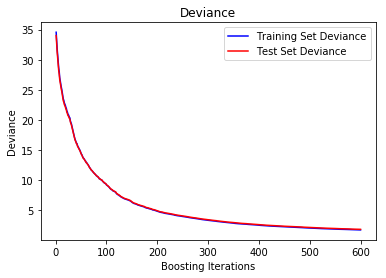

In [127]:
import matplotlib.pyplot as plt

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(est.staged_predict(x_test)):
    test_score[i] = est.loss_(y_test, y_pred)

plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, est.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.show()

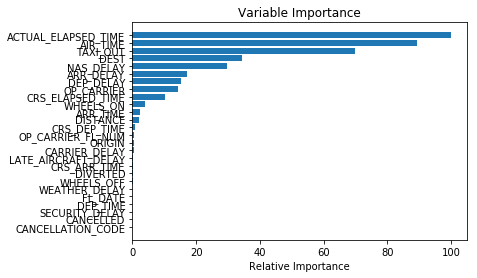

In [128]:
# #############################################################################
# Plot feature importance
feature_importance = est.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feat_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
